# Import Libraries

In [23]:
import pandas as pd
import numpy as np
import sklearn
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

# Data Pre-Processing

In [24]:
coffee_data = pd.read_excel('coffee_data.xlsx')
fuel_data = pd.read_excel('fuel_data.xlsx')
#tomato_data = pd.read_excel('tomato_data.xls')

### Filter Coffee data

In [25]:
coffee_data['Ngày'] = pd.to_datetime(coffee_data['Ngày'])
coffee_data['Giá Cà Phê'] =  coffee_data['Giá']
coffee_data.drop(coffee_data.columns[[0, 1, 2, 3, 5]], axis=1, inplace=True)
coffee_data.head(5)

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-04,32717.0
2,2021-01-05,32417.0
3,2021-01-06,32317.0
4,2021-01-07,32117.0


### Filter Tomato data

In [26]:
# tomato_data['Ngày'] = pd.to_datetime(tomato_data['Ngày tháng'])
# tomato_data.drop(tomato_data.columns[[0, 1, 2, 3, 5]], axis=1, inplace=True)
# tomato_data.head(5)

### Filter Diesel data

In [27]:
fuel_data["Ngày"] = pd.to_datetime(fuel_data["Giá nhiên liệu"], format="%d.%m.%Y")
fuel_data.drop(fuel_data.columns[[0,1,2,4]], axis='columns', inplace=True)
# reverse the order
fuel_data = fuel_data[::-1]
fuel_data.head(5)

,Dầu Diesel 1 lít,Ngày
118,14.90,2019-01-01
117,14.90,2019-01-16
116,14.90,2019-01-31
115,14.90,2019-02-15
114,15.86,2019-03-02


# GRU model

In [28]:
coffee_data.head(5)

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-04,32717.0
2,2021-01-05,32417.0
3,2021-01-06,32317.0
4,2021-01-07,32117.0


In [29]:
# drop date column
coffee_data.drop(coffee_data.columns[[0]], axis=1, inplace=True)
coffee_data.dropna()

,Giá Cà Phê
0,31667.5
1,32717.0
2,32417.0
3,32317.0
4,32117.0
...,...
619,55566.5
620,56066.5
621,56666.5
622,57000.0


In [30]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
# load dataset
values = coffee_data.values
values

array([[31667.5 ],
       [32717.  ],
       [32417.  ],
       [32317.  ],
       [32117.  ],
       [31817.  ],
       [31517.  ],
       [31417.  ],
       [31217.  ],
       [31817.  ],
       [31717.  ],
       [32017.  ],
       [31617.  ],
       [31717.  ],
       [31617.  ],
       [31333.5 ],
       [31117.  ],
       [31117.  ],
       [31317.  ],
       [31317.  ],
       [31117.  ],
       [31459.  ],
       [31517.  ],
       [31067.  ],
       [31267.  ],
       [31417.  ],
       [31417.  ],
       [31617.  ],
       [31717.  ],
       [31517.  ],
       [31633.5 ],
       [31400.  ],
       [31367.  ],
       [31567.  ],
       [31667.  ],
       [31567.  ],
       [32267.  ],
       [32667.  ],
       [32667.  ],
       [32767.  ],
       [32388.75],
       [32575.  ],
       [32475.  ],
       [32375.  ],
       [32275.  ],
       [32075.  ],
       [31725.  ],
       [32350.  ],
       [32425.  ],
       [32525.  ],
       [32266.5 ],
       [32133.5 ],
       [3248

In [32]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [33]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var1(t)
1,0.022718,0.062422
2,0.062422,0.051073
3,0.051073,0.047289
4,0.047289,0.039723
5,0.039723,0.028374
...,...,...
619,0.868214,0.926853
620,0.926853,0.945769
621,0.945769,0.968467
622,0.968467,0.981084


In [34]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)
dataset = reframed
dataset.head()

,var1(t-1)
1,0.022718
2,0.062422
3,0.051073
4,0.047289
5,0.039723


In [35]:
dataset = reframed.values

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

498 125


In [36]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(498, 1, 0) (498,) (125, 1, 0) (125,)


In [37]:
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')

In [38]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 1, 75)             17325     
                                                                 
 gru_4 (GRU)                 (None, 1, 30)             9630      
                                                                 
 gru_5 (GRU)                 (None, 30)                5580      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 32,566
Trainable params: 32,566
Non-trainable params: 0
_________________________________________________________________


In [39]:
# fit network
gru_history = model_gru.fit(train_X, train_y, epochs=10,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/10
8/8 [==============================] - 5s 111ms/step - loss: 0.2715 - val_loss: 0.4708
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2197 - val_loss: 0.4062
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1855 - val_loss: 0.3389
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1557 - val_loss: 0.2681
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1320 - val_loss: 0.2030
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.1334 - val_loss: 0.1879
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1439 - val_loss: 0.1946
Epoch 8/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1419 - val_loss: 0.2052
Epoch 9/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1393 - val_loss: 0.2068
Epoch 10/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1373 - val_loss: 0.2020


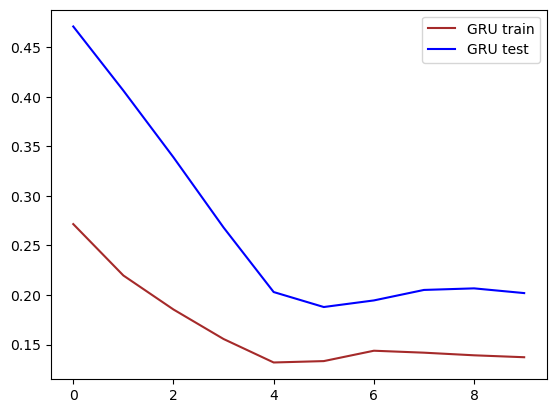

In [40]:
#dont run this cell if you are running this cell than add "validation_data=(test_X, test_y)" in model_gru.fit()
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
pyplot.legend()
pyplot.show()

In [41]:
# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    print('\nRMSE')
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    print('\nMAE')
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('Test Score: %.2f MAE' % (testScore))
    
    print('\nMAPE')                          
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('Test Score: %.2f MAPE' % (testScore))
    
    print('\nMASE')
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('Test Score: %.2f MASE' % (testScore))

In [42]:
# make a prediction
test_pred = model_gru.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

4/4 [==============================] - 1s 1ms/step


In [43]:
# invert scaling for forecast
inv_test_pred = concatenate((test_pred, test_X[:, 1:]), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [44]:
# print results
print_metrics(inv_y, inv_test_pred)


RMSE
Test Score: 7059.11 RMSE

MAE
Test Score: 5339.38 MAE

MAPE
Test Score: 0.11 MAPE

MASE
Test Score: 19.98 MASE
